In [1]:
import pickle as pkl
import scipy.sparse as sp
from scipy.sparse.linalg.eigen.arpack import eigsh
import sys

import random
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import tensorflow as tf

C:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


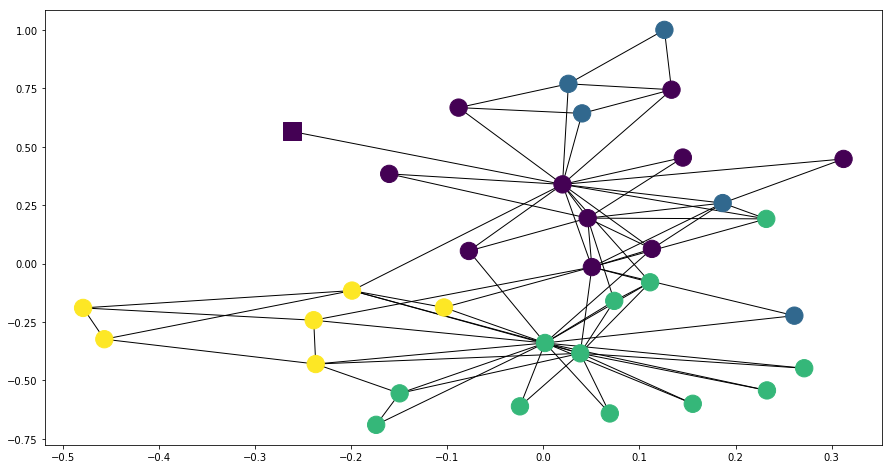

In [2]:
g = nx.read_graphml('D:/bigdata/Python/Graph Neural Net/R/karate.graphml')

m=list(nx.get_node_attributes(g , 'membership').values())
plt.figure(figsize=(15,8))
pos = nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos ,nodelist=['n11'],node_color=[m[0]], node_shape='s')
nx.draw_networkx_nodes(g, pos ,nodelist=['n'+str(i) for i in range(34) if i!=11],node_color=m[1:], node_shape='o')
nx.draw_networkx_edges(g,pos)
# Get important parameters of adjacency matrix
adj = nx.adj_matrix(g)
n_nodes = adj.shape[0]
adj_tilde = adj + np.identity(n=adj.shape[0], dtype=np.float32)
numpy_adj=adj_tilde-np.identity(n=adj.shape[0], dtype=np.float32)
d_tilde_diag = np.squeeze(np.sum(np.array(adj_tilde), axis=1))
d_tilde_inv_sqrt_diag = np.power(d_tilde_diag, -1/2, dtype=np.float32)
d_tilde_inv_sqrt = np.diag(d_tilde_inv_sqrt_diag)
adj_norm = np.dot(np.dot(d_tilde_inv_sqrt, adj_tilde), d_tilde_inv_sqrt)
adj_norm=adj_norm.astype(np.float32)
feat_x = np.identity(n=adj.shape[0])

In [3]:
# Semi-supervised
memberships = [m - 1 for m in nx.get_node_attributes(g, 'membership').values()]

nb_classes = len(set(memberships))
targets = np.array([memberships], dtype=np.int32).reshape(-1)
one_hot_targets = np.eye(4)[targets]

# Pick 3 from each class
labels_to_keep=[17,2,3,  4,6,5,  15,9,20,  27,24,31]

y_train = np.zeros(shape=one_hot_targets.shape,
                   dtype=np.float32)
y_test = one_hot_targets.copy()

train_mask = np.zeros(shape=(n_nodes,), dtype=np.bool)
test_mask = np.ones(shape=(n_nodes,), dtype=np.bool)

for l in labels_to_keep:
    y_train[l, :] = one_hot_targets[l, :]
    y_test[l, :] = np.zeros(shape=(nb_classes,))
    train_mask[l] = True
    test_mask[l] = False

In [4]:
class JKNet:
    def __init__(self, layer, n_nodes, f_dimension, nb_classes, initializer=tf.contrib.layers.xavier_initializer(uniform=False)):
        self.X = tf.placeholder('float32',shape=(n_nodes*f_dimension))
        self.y = tf.placeholder('float32', shape=(n_nodes, nb_classes))
        self.mask=tf.placeholder('float32')
        self.nodes=n_nodes
        self.output_dim = nb_classes
        self.layer = layer
        self.is_train=tf.placeholder(tf.bool)
        self.adj=tf.placeholder('float32',shape=(n_nodes, n_nodes))
        self.dropout=tf.placeholder(tf.float32)
        self.init=initializer
        
    def loss(self, lr, active=tf.nn.relu, optim=tf.train.AdamOptimizer, JK_Model='concat'):
        self.L=tf.identity(tf.reshape(self.X, [self.nodes, -1]))
        _layers= []
        for i in range(len(self.layer)):
            self.L=self.graph_conv(self.L, self.adj, self.layer[i], activation=active)
            self.L= tf.nn.dropout(self.L, self.dropout)
            _layers.append(self.L)
            
        if JK_Model=='concat':
            hypo= tf.concat(_layers, axis=1)  
            self.hypothesis=tf.layers.dense(hypo, self.output_dim, activation=tf.nn.softmax, kernel_initializer=self.init)
            
        elif JK_Model=='MaxPooling':
            hypo= tf.stack(_layers, axis=0)   
            hypo = tf.reduce_max(hypo, axis=0)
            self.hypothesis=tf.layers.dense(hypo, self.output_dim, activation=tf.nn.softmax, kernel_initializer=self.init)
            
        elif JK_Model=='Bi-LSTM Attention':
            self.Attention=self.Bi_directional_lstm_attention(_layers)
            hypo=0
            for i in range(len(_layers)):
                hypo+=self.Attention[i]*_layers[i]
            self.hypothesis=tf.layers.dense(hypo, self.output_dim, activation=tf.nn.softmax, kernel_initializer=self.init)
            
        elif JK_Model=='Only_GCN':
            hypo=self.L
            self.hypothesis=tf.layers.dense(self.L, self.output_dim, activation=tf.nn.softmax, kernel_initializer=self.init)
            
        elif JK_Model=='Only_GAT':
            self.hidden_layer=tf.identity(self.L)
            for i, hidden_layer in enumerate(self.layer):
                self.hidden_layer = tf.layers.dense(self.hidden_layer, hidden_layer, kernel_initializer=self.init)
                self.coeffs = self.attn_coeffs_DGL(self.hidden_layer, self.adj)
                self.hidden_layer = tf.matmul(self.coeffs, self.hidden_layer) # [batch_size, num_nodes, num_nodes]  
                self.hidden_layer = tf.matmul(self.adj, self.hidden_layer)
                self.hidden_layer = active(self.hidden_layer)
                self.hidden_layer = tf.nn.dropout( self.hidden_layer, self.dropout)
            hypo=self.hidden_layer
            self.hypothesis = tf.layers.dense(hypo, self.output_dim, activation=tf.nn.softmax, kernel_initializer=self.init)
        else:
            raise ValueError("You should assign JK_model")
        
        
        
        
        self.influence=self.Influence_x_y(11, hypo)
        
        
        var   = tf.trainable_variables()     
        lossL2 = tf.add_n([ tf.nn.l2_loss(v) for v in var if 'bias' not in v.name ]) *  0.0005  
        
        self.cost=tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.y, logits=self.hypothesis)+lossL2
        mask = tf.cast(self.mask, dtype=tf.float32)
        mask /= tf.reduce_mean(mask)
        

        self.cost *= mask       
        self.cost=tf.reduce_mean(self.cost)
        
        self.optimizer = optim(learning_rate=lr)
        self.trains = self.optimizer.minimize(self.cost)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def graph_conv(self, _X, _A, output_dim, activation=tf.nn.relu):
        output = tf.layers.dense(_X, units=output_dim, kernel_initializer=self.init)
        output = tf.matmul(_A, output)
        output = activation(output)
        return output
    
    def Bi_directional_lstm_attention(self, Layer):
        l=[]
        for layer in Layer:
            l.append(tf.reshape(layer, [1,-1]))
        X=tf.stack(l, axis=1)
        
        lstm_fw_cell = tf.nn.rnn_cell.LSTMCell(num_units = self.layer[0], state_is_tuple = True)
        lstm_fw_cell = tf.nn.rnn_cell.DropoutWrapper(lstm_fw_cell, output_keep_prob=self.dropout)
        
        lstm_bw_cell = tf.nn.rnn_cell.LSTMCell(num_units = self.layer[0], state_is_tuple = True)
        lstm_bw_cell = tf.nn.rnn_cell.DropoutWrapper(lstm_bw_cell, output_keep_prob=self.dropout)
        
        outputs,_ = tf.nn.bidirectional_dynamic_rnn(lstm_fw_cell,lstm_bw_cell, X, dtype = tf.float32)

        outputs_fw = tf.reshape(outputs[0], [len(Layer),self.layer[0]])
        outputs_bw = tf.reshape(outputs[1], [len(Layer),self.layer[0]])
        outputs_concat = tf.concat([outputs_fw, outputs_bw], axis=1)
        concatenated=tf.layers.dense(outputs_concat, units=1, use_bias=True, kernel_initializer=self.init)
        s=tf.nn.softmax(tf.reshape(concatenated,[-1]))
        return s
                    
    def Influence_x_y(self, Node_x, hypo):
        abs_grad=tf.math.abs(tf.gradients(tf.reshape(hypo[Node_x], [-1]), self.X)[0])
        abs_grad=tf.reshape(abs_grad,[self.nodes,-1])
        jacobian=tf.reduce_sum(abs_grad,axis=1)
        Influence_of_Y_ON_X=jacobian/tf.reduce_sum(jacobian)
        return Influence_of_Y_ON_X
        
    def attn_coeffs_DGL(self, H, A):
        H=tf.matmul(A,H)
        logits = tf.layers.dense(H, self.nodes,activation=tf.nn.leaky_relu)
        zero_vec = -9e15*tf.ones_like(logits)
        attention = tf.where(A > 0, logits, zero_vec)
        coefs = tf.nn.softmax(attention, axis=1)
        return coefs
    
    def accuracy(self, X, Y, mask, adj):
        """Accuracy with masking."""
        preds, influence=self.sess.run([self.hypothesis, self.influence], feed_dict={self.X:X, self.y:Y, self.adj:adj,
                                                                              self.mask:mask, self.dropout:1})
        correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(Y, 1))
        accuracy_all = tf.cast(correct_prediction, tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        mask /= tf.reduce_mean(mask)
        accuracy_all *= mask
        return self.sess.run(tf.reduce_mean(accuracy_all)), influence
    
        
    
    def train(self, batch_xs, batch_ys, mask, avg_cost, adj):
        _, c = self.sess.run([self.trains, self.cost], feed_dict={self.X: batch_xs, self.y: batch_ys,  self.adj:adj,
                                                                  self.mask:mask, self.dropout:0.5})
        avg_cost += np.mean(c)
        return avg_cost
    



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [5]:
tf.reset_default_graph()
model=JKNet([16,16,16,16], 34, 34, 4)
model.loss(1e-2, active=tf.nn.relu, JK_Model='Only_GCN')
for epoch in range(6):
    avg_cost=0
    for i in range(50):
        batch_xs, batch_ys, adj = feat_x.reshape(-1),  y_train, np.array(adj_norm)
        avg_cost=model.train(batch_xs, batch_ys, train_mask, avg_cost/50, adj)
    train_acc, influe=model.accuracy(batch_xs, batch_ys, train_mask, adj)
    test_acc, _=model.accuracy(batch_xs, y_test, test_mask, adj)
    print('Epoch:','%04d' %(epoch+1),'cost=', np.round(avg_cost,5),'train_acc: ',train_acc, '  test_acc: ',test_acc)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch: 0001 cost= 1.37375 train_acc:  0.25   test_acc:  0.40909088
Epoch: 0002 cost= 1.2987 train_acc:  0.5   test_acc:  0.45454544
Epoch: 0003 cost= 1.14937 train_acc:  0.75   test_acc:  0.7272727
Epoch: 0004 cost= 1.10465 train_acc:  0.8333333   test_acc:  0.7272727
Epoch: 0005 cost= 1.03346 train_acc:  0.75   test_acc:  0.6818182
Epoch: 0006 cost= 1.01248 train_acc:  1.0   test_acc:  0.7272727


# Influence distribution of 4-Layer GCN

C:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


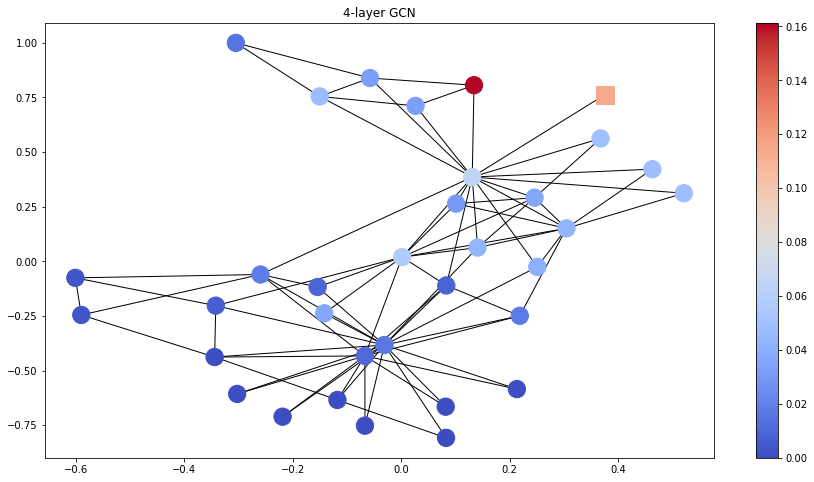

In [6]:
plt.figure(figsize=(15,8))
plt.title('4-layer GCN')
pos = nx.spring_layout(g)
cmap = plt.cm.coolwarm
nx.draw_networkx_nodes(g, pos ,nodelist=['n11'],node_color=[influe[0]], node_shape='s',  cmap=cmap,vmin=0, vmax=influe.max())
nx.draw_networkx_nodes(g, pos ,nodelist=['n'+str(i) for i in range(34) if i!=11],node_color=influe[1:], node_shape='o', cmap=cmap, vmin=0, vmax=influe.max())
nx.draw_networkx_edges(g,pos)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=influe.max()))
sm.set_array([])
cbar = plt.colorbar(sm)
plt.show()

In [7]:
tf.reset_default_graph()
model=JKNet([16,16,16,16], 34, 34, 4)
model.loss(1e-2, active=tf.nn.relu, JK_Model='Only_GAT')
for epoch in range(6):
    avg_cost=0
    for i in range(50):
        batch_xs, batch_ys, adj = feat_x.reshape(-1),  y_train, np.array(adj_norm)
        avg_cost=model.train(batch_xs, batch_ys, train_mask, avg_cost/50, adj)
    train_acc, influe=model.accuracy(batch_xs, batch_ys, train_mask, adj)
    test_acc, _=model.accuracy(batch_xs, y_test, test_mask, adj)
    print('Epoch:','%04d' %(epoch+1),'cost=', np.round(avg_cost,5),'train_acc: ',train_acc, '  test_acc: ',test_acc)

Epoch: 0001 cost= 1.37286 train_acc:  0.25   test_acc:  0.36363634
Epoch: 0002 cost= 1.35967 train_acc:  0.5   test_acc:  0.36363634
Epoch: 0003 cost= 1.31387 train_acc:  0.75   test_acc:  0.59090906
Epoch: 0004 cost= 1.26378 train_acc:  0.5   test_acc:  0.36363634
Epoch: 0005 cost= 1.11554 train_acc:  0.75   test_acc:  0.45454544
Epoch: 0006 cost= 1.14475 train_acc:  0.75   test_acc:  0.45454544


# Influence distribution of 4-Layer GAT

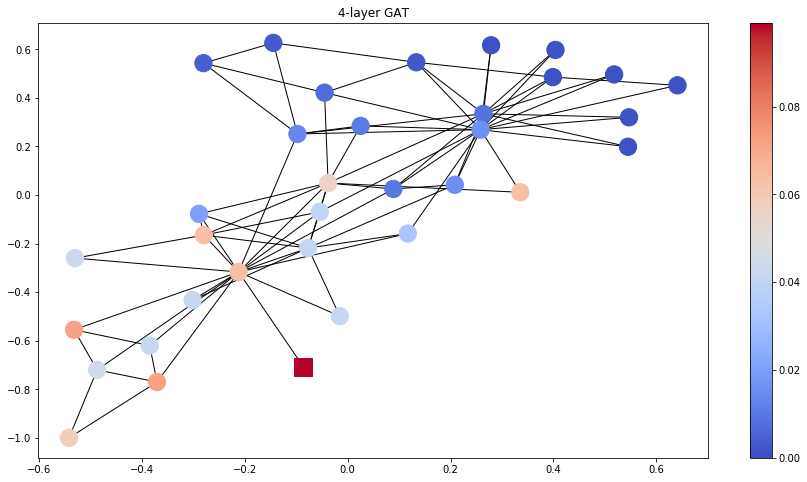

In [8]:
plt.figure(figsize=(15,8))
plt.title('4-layer GAT')
pos = nx.spring_layout(g)
cmap = plt.cm.coolwarm
nx.draw_networkx_nodes(g, pos ,nodelist=['n11'],node_color=[influe[0]], node_shape='s',  cmap=cmap,vmin=0, vmax=influe.max())
nx.draw_networkx_nodes(g, pos ,nodelist=['n'+str(i) for i in range(34) if i!=11],node_color=influe[1:], node_shape='o', cmap=cmap, vmin=0, vmax=influe.max())
nx.draw_networkx_edges(g,pos)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=influe.max()))
sm.set_array([])
cbar = plt.colorbar(sm)
plt.show()

In [9]:
tf.reset_default_graph()
model=JKNet([16,16,16,16], 34, 34, 4)
model.loss(1e-2, active=tf.nn.relu, JK_Model='concat')
for epoch in range(6):
    avg_cost=0
    for i in range(50):
        batch_xs, batch_ys, adj = feat_x.reshape(-1),  y_train, np.array(adj_norm)
        avg_cost=model.train(batch_xs, batch_ys, train_mask, avg_cost/50, adj)
    train_acc, influe=model.accuracy(batch_xs, batch_ys, train_mask, adj)
    test_acc, _=model.accuracy(batch_xs, y_test, test_mask, adj)
    print('Epoch:','%04d' %(epoch+1),'cost=', np.round(avg_cost,5),'train_acc: ',train_acc, '  test_acc: ',test_acc)

Epoch: 0001 cost= 0.91554 train_acc:  1.0   test_acc:  1.0
Epoch: 0002 cost= 0.83611 train_acc:  1.0   test_acc:  1.0
Epoch: 0003 cost= 0.85783 train_acc:  1.0   test_acc:  1.0
Epoch: 0004 cost= 0.88114 train_acc:  1.0   test_acc:  0.9090908
Epoch: 0005 cost= 0.80567 train_acc:  1.0   test_acc:  0.95454544
Epoch: 0006 cost= 0.81534 train_acc:  1.0   test_acc:  1.0


# Influence distribution of 4-Layer CONCATENATION

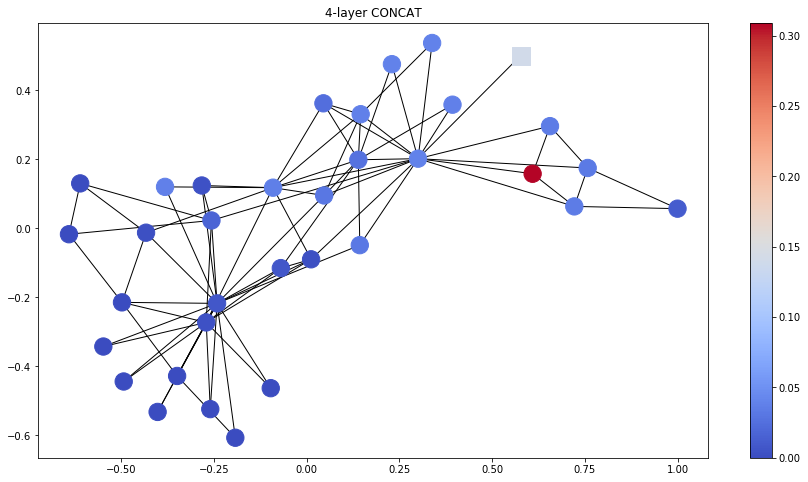

In [10]:
plt.figure(figsize=(15,8))
plt.title('4-layer CONCAT')
pos = nx.spring_layout(g)
cmap = plt.cm.coolwarm
nx.draw_networkx_nodes(g, pos ,nodelist=['n11'],node_color=[influe[0]], node_shape='s',  cmap=cmap,vmin=0, vmax=influe.max())
nx.draw_networkx_nodes(g, pos ,nodelist=['n'+str(i) for i in range(34) if i!=11],node_color=influe[1:], node_shape='o', cmap=cmap, vmin=0, vmax=influe.max())
nx.draw_networkx_edges(g,pos)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=influe.max()))
sm.set_array([])
cbar = plt.colorbar(sm)
plt.show()

In [11]:
tf.reset_default_graph()
model=JKNet([16,16,16,16], 34, 34, 4)
model.loss(1e-2, active=tf.nn.relu, JK_Model='MaxPooling')
for epoch in range(6):
    avg_cost=0
    for i in range(50):
        batch_xs, batch_ys, adj = feat_x.reshape(-1),  y_train, np.array(adj_norm)
        avg_cost=model.train(batch_xs, batch_ys, train_mask, avg_cost/50, adj)
    train_acc, influe=model.accuracy(batch_xs, batch_ys, train_mask, adj)
    test_acc, _=model.accuracy(batch_xs, y_test, test_mask, adj)
    print('Epoch:','%04d' %(epoch+1),'cost=', np.round(avg_cost,5),'train_acc: ',train_acc, '  test_acc: ',test_acc)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch: 0001 cost= 1.00806 train_acc:  0.75   test_acc:  0.8636363
Epoch: 0002 cost= 0.87338 train_acc:  1.0   test_acc:  1.0
Epoch: 0003 cost= 0.90281 train_acc:  1.0   test_acc:  0.9090908
Epoch: 0004 cost= 0.82229 train_acc:  1.0   test_acc:  1.0
Epoch: 0005 cost= 0.80847 train_acc:  1.0   test_acc:  0.9090908
Epoch: 0006 cost= 0.80597 train_acc:  1.0   test_acc:  0.9090908


# Influence distribution of 4-Layer MAXPOOLING

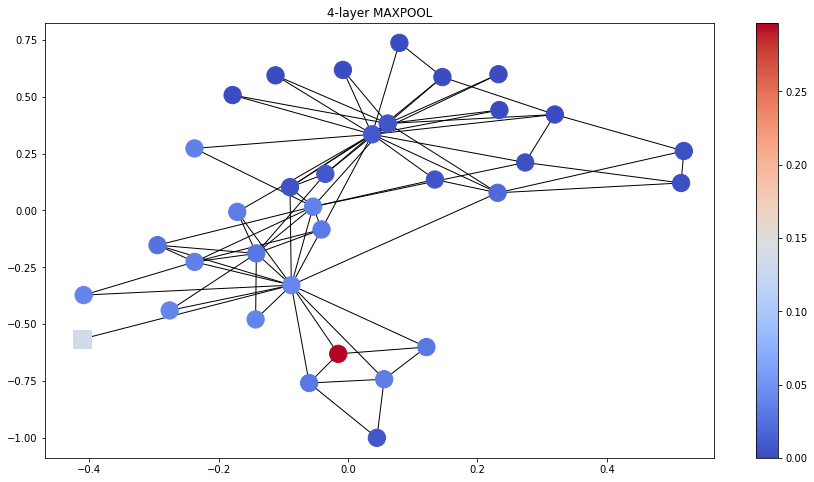

In [12]:
plt.figure(figsize=(15,8))
plt.title('4-layer MAXPOOL')
pos = nx.spring_layout(g)
cmap = plt.cm.coolwarm
nx.draw_networkx_nodes(g, pos ,nodelist=['n11'],node_color=[influe[0]], node_shape='s',  cmap=cmap,vmin=0, vmax=influe.max())
nx.draw_networkx_nodes(g, pos ,nodelist=['n'+str(i) for i in range(34) if i!=11],node_color=influe[1:], node_shape='o', cmap=cmap, vmin=0, vmax=influe.max())
nx.draw_networkx_edges(g,pos)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=influe.max()))
sm.set_array([])
cbar = plt.colorbar(sm)
plt.show()

In [13]:
tf.reset_default_graph()
model=JKNet([16,16,16,16], 34, 34, 4)
model.loss(1e-2, active=tf.nn.relu, JK_Model='Bi-LSTM Attention')
for epoch in range(6):
    avg_cost=0
    for i in range(50):
        batch_xs, batch_ys, adj = feat_x.reshape(-1),  y_train, np.array(adj_norm)
        avg_cost=model.train(batch_xs, batch_ys, train_mask, avg_cost/50, adj)
    train_acc, influe=model.accuracy(batch_xs, batch_ys, train_mask, adj)
    test_acc, _=model.accuracy(batch_xs, y_test, test_mask, adj)
    print('Epoch:','%04d' %(epoch+1),'cost=', np.round(avg_cost,5),'train_acc: ',train_acc, '  test_acc: ',test_acc)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Epoch: 0001 cost= 1.08033 train_acc:  1.0   test_acc:  0.8636364
Epoch: 0002 cost= 0.95266 train_acc:  1.0   test_acc:  0.95454544
Epoch: 0003 cost= 0.86159 train_acc:  1.0   test_acc:  0.8636363
Epoch: 0004 cost= 0.92936 train_acc:  1.0   test_acc:  0.8636363
Epoch: 0005 cost= 0.91528 train_acc:  1.0   test_acc:  0.8636363
Epoch: 0006 cost= 0.88612 train_acc:  1.0   test_acc:  0.81818175


# Influence distribution of 4-Layer BI-LSTM ATTENTION

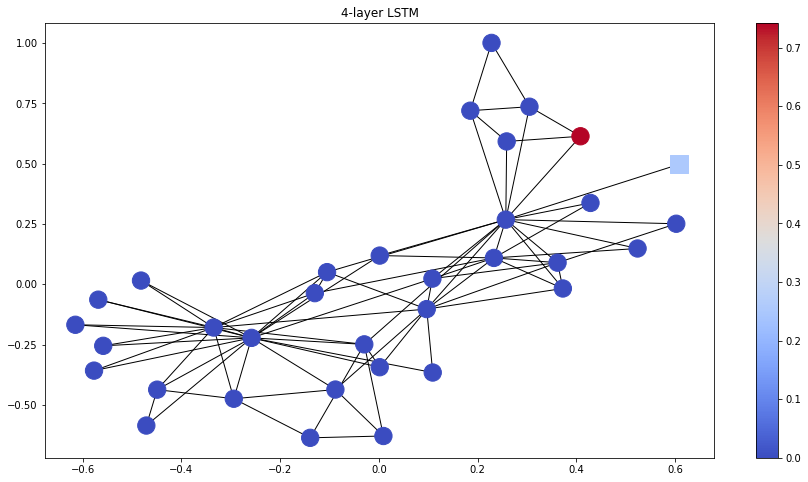

In [14]:
plt.figure(figsize=(15,8))
plt.title('4-layer LSTM')
pos = nx.spring_layout(g)
cmap = plt.cm.coolwarm
nx.draw_networkx_nodes(g, pos ,nodelist=['n11'],node_color=[influe[0]], node_shape='s',  cmap=cmap,vmin=0, vmax=influe.max())
nx.draw_networkx_nodes(g, pos ,nodelist=['n'+str(i) for i in range(34) if i!=11],node_color=influe[1:], node_shape='o', cmap=cmap, vmin=0, vmax=influe.max())
nx.draw_networkx_edges(g,pos)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=influe.max()))
sm.set_array([])
cbar = plt.colorbar(sm)
plt.show()

# Cora Datasets

In [15]:
def parse_index_file(filename):
    """Parse index file."""
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index


def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)


def load_data(dataset_str):
    """
    Loads input data from gcn/data directory

    ind.dataset_str.x => the feature vectors of the training instances as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.tx => the feature vectors of the test instances as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.allx => the feature vectors of both labeled and unlabeled training instances
        (a superset of ind.dataset_str.x) as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.y => the one-hot labels of the labeled training instances as numpy.ndarray object;
    ind.dataset_str.ty => the one-hot labels of the test instances as numpy.ndarray object;
    ind.dataset_str.ally => the labels for instances in ind.dataset_str.allx as numpy.ndarray object;
    ind.dataset_str.graph => a dict in the format {index: [index_of_neighbor_nodes]} as collections.defaultdict
        object;
    ind.dataset_str.test.index => the indices of test instances in graph, for the inductive setting as list object.

    All objects above must be saved using python pickle module.

    :param dataset_str: Dataset name
    :return: All data input files loaded (as well the training/test data).
    """
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for i in range(len(names)):
        with open("D:/bigdata/Python/Graph Neural Net/Graph-neural-networks-master/tutorials/data/ind.{}.{}".format(dataset_str, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    x, y, tx, ty, allx, ally, graph = tuple(objects)
    test_idx_reorder = parse_index_file("D:/bigdata/Python/Graph Neural Net/Graph-neural-networks-master/tutorials/data/ind.{}.test.index".format(dataset_str))
    test_idx_range = np.sort(test_idx_reorder)
    if dataset_str == 'citeseer':
        # Fix citeseer dataset (there are some isolated nodes in the graph)
        # Find isolated nodes, add them as zero-vecs into the right position
        test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        tx_extended[test_idx_range-min(test_idx_range), :] = tx
        tx = tx_extended
        ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
        ty_extended[test_idx_range-min(test_idx_range), :] = ty
        ty = ty_extended

    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]
    
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))

    labels = np.vstack((ally, ty))
    labels[test_idx_reorder, :] = labels[test_idx_range, :]

    idx_test = np.random.choice(2708, int(2708*0.2), replace=False)
    without_test=np.array([i for i in range(2708) if i not in idx_test ])
    idx_train = without_test[np.random.choice(np.arange(len(without_test)),int(2708*0.6), replace=False)]
    idx_val = np.array([i for i in range(2708) if i not in idx_test if i not in idx_train])

    train_mask = sample_mask(idx_train, labels.shape[0])
    val_mask = sample_mask(idx_val, labels.shape[0])
    test_mask = sample_mask(idx_test, labels.shape[0])

    y_train = np.zeros(labels.shape)
    y_val = np.zeros(labels.shape)
    y_test = np.zeros(labels.shape)
    y_train[train_mask, :] = labels[train_mask, :]
    y_val[val_mask, :] = labels[val_mask, :]
    y_test[test_mask, :] = labels[test_mask, :]

    return adj, features, np.array(y_train), np.array(y_val), np.array(y_test), np.array(train_mask), np.array(val_mask), np.array(test_mask), graph


def sparse_to_tuple(sparse_mx):
    """Convert sparse matrix to tuple representation."""
    def to_tuple(mx):
        if not sp.isspmatrix_coo(mx):
            mx = mx.tocoo()
        coords = np.vstack((mx.row, mx.col)).transpose()
        values = mx.data
        shape = mx.shape
        return coords, values, shape

    if isinstance(sparse_mx, list):
        for i in range(len(sparse_mx)):
            sparse_mx[i] = to_tuple(sparse_mx[i])
    else:
        sparse_mx = to_tuple(sparse_mx)

    return sparse_mx


def preprocess_features(features):
    """Row-normalize feature matrix and convert to tuple representation"""
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    return sparse_to_tuple(features)


def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()


def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    return sparse_to_tuple(adj_normalized)


def construct_feed_dict(features, support, labels, labels_mask, placeholders):
    """Construct feed dictionary."""
    feed_dict = dict()
    feed_dict.update({placeholders['labels']: labels})
    feed_dict.update({placeholders['labels_mask']: labels_mask})
    feed_dict.update({placeholders['features']: features})
    feed_dict.update({placeholders['support'][i]: support[i] for i in range(len(support))})
    feed_dict.update({placeholders['num_features_nonzero']: features[1].shape})
    return feed_dict


def chebyshev_polynomials(adj, k):
    """Calculate Chebyshev polynomials up to order k. Return a list of sparse matrices (tuple representation)."""
    print("Calculating Chebyshev polynomials up to order {}...".format(k))

    adj_normalized = normalize_adj(adj)
    laplacian = sp.eye(adj.shape[0]) - adj_normalized
    largest_eigval, _ = eigsh(laplacian, 1, which='LM')
    scaled_laplacian = (2. / largest_eigval[0]) * laplacian - sp.eye(adj.shape[0])

    t_k = list()
    t_k.append(sp.eye(adj.shape[0]))
    t_k.append(scaled_laplacian)

    def chebyshev_recurrence(t_k_minus_one, t_k_minus_two, scaled_lap):
        s_lap = sp.csr_matrix(scaled_lap, copy=True)
        return 2 * s_lap.dot(t_k_minus_one) - t_k_minus_two

    for i in range(2, k+1):
        t_k.append(chebyshev_recurrence(t_k[-1], t_k[-2], scaled_laplacian))

    return sparse_to_tuple(t_k)


In [16]:
adj_cora, features_cora, y_train_cora, y_val_cora, y_test_cora, train_mask_cora, val_mask_cora, test_mask_cora, cora_graph = load_data('cora')

In [17]:
features_cora=np.array(features_cora.todense())

In [18]:
adj_norm_cora = normalize_adj(adj_cora + sp.eye(adj_cora.shape[0]))
adj_norm_cora=adj_norm_cora.todense()
adj_norm_cora=np.array(adj_norm_cora.astype(np.float32))

In [19]:
print('feature shape: ',features_cora.shape)
print('adj_norm_cora shape: ',adj_norm_cora.shape)
print('y_train_cora shape: ',y_train_cora.shape)

feature shape:  (2708, 1433)
adj_norm_cora shape:  (2708, 2708)
y_train_cora shape:  (2708, 7)


# GCN

In [20]:
tf.reset_default_graph()
model_cora=JKNet([32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='Only_GCN')
outputs={}
val_acc_prev=0
for epoch in range(10):
    avg_cost=0
    for i in range(100):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, outputs[epoch]=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    val_acc, _=model_cora.accuracy(batch_xs, y_val_cora, val_mask_cora, adj)
    if val_acc>val_acc_prev:
        val_acc_prev=val_acc
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc,  ' val_acc: ' ,val_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)
print('Top_Validation_Acc: ',val_acc_prev)

Epoch: 0001 train_acc:  0.95935714  val_acc:  0.8747698
Epoch: 0002 train_acc:  0.9729039  val_acc:  0.8729282
Epoch: 0003 train_acc:  0.97844577  val_acc:  0.86924505
Epoch: 0004 train_acc:  0.98029304  val_acc:  0.8729283
Epoch: 0005 train_acc:  0.9815246  val_acc:  0.86924505
Epoch: 0006 train_acc:  0.9827561  val_acc:  0.87108666
Epoch: 0007 train_acc:  0.9827561  val_acc:  0.87108666
Epoch: 0008 train_acc:  0.98460335  val_acc:  0.86924493
Epoch: 0009 train_acc:  0.98337185  val_acc:  0.86924493
Epoch: 0010 train_acc:  0.9839876  val_acc:  0.8637201
Test_acc:  0.8743066
Top_Validation_Acc:  0.8747698


In [21]:
tf.reset_default_graph()
model_cora=JKNet([32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='Only_GCN')
outputs={}
val_acc_prev=0
for epoch in range(10):
    avg_cost=0
    for i in range(100):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, outputs[epoch]=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    val_acc, _=model_cora.accuracy(batch_xs, y_val_cora, val_mask_cora, adj)
    if val_acc>val_acc_prev:
        val_acc_prev=val_acc
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc,  ' val_acc: ' ,val_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)
print('Top_Validation_Acc: ',val_acc_prev)

Epoch: 0001 train_acc:  0.95012075  val_acc:  0.88029474
Epoch: 0002 train_acc:  0.9679778  val_acc:  0.88029474
Epoch: 0003 train_acc:  0.97228813  val_acc:  0.88766134
Epoch: 0004 train_acc:  0.9735197  val_acc:  0.87661153
Epoch: 0005 train_acc:  0.9747512  val_acc:  0.88029474
Epoch: 0006 train_acc:  0.9759827  val_acc:  0.87661153
Epoch: 0007 train_acc:  0.9759827  val_acc:  0.88029474
Epoch: 0008 train_acc:  0.97844577  val_acc:  0.87845314
Epoch: 0009 train_acc:  0.97783  val_acc:  0.88029474
Epoch: 0010 train_acc:  0.9772142  val_acc:  0.88029474
Test_acc:  0.8743066
Top_Validation_Acc:  0.88766134


In [22]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='Only_GCN')
outputs={}
val_acc_prev=0
for epoch in range(10):
    avg_cost=0
    for i in range(100):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, outputs[epoch]=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    val_acc, _=model_cora.accuracy(batch_xs, y_val_cora, val_mask_cora, adj)
    if val_acc>val_acc_prev:
        val_acc_prev=val_acc
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc,  ' val_acc: ' ,val_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)
print('Top_Validation_Acc: ',val_acc_prev)

Epoch: 0001 train_acc:  0.92856914  val_acc:  0.88029474
Epoch: 0002 train_acc:  0.9476577  val_acc:  0.8821364
Epoch: 0003 train_acc:  0.9525838  val_acc:  0.88029474
Epoch: 0004 train_acc:  0.9513523  val_acc:  0.88029474
Epoch: 0005 train_acc:  0.95504683  val_acc:  0.88029474
Epoch: 0006 train_acc:  0.95443106  val_acc:  0.87845314
Epoch: 0007 train_acc:  0.95504683  val_acc:  0.8747698
Epoch: 0008 train_acc:  0.9556626  val_acc:  0.86924505
Epoch: 0009 train_acc:  0.9562784  val_acc:  0.88029474
Epoch: 0010 train_acc:  0.95504683  val_acc:  0.87845314
Test_acc:  0.86506444
Top_Validation_Acc:  0.8821364


In [23]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32, 32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='Only_GCN')
outputs={}
val_acc_prev=0
for epoch in range(10):
    avg_cost=0
    for i in range(100):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, outputs[epoch]=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    val_acc, _=model_cora.accuracy(batch_xs, y_val_cora, val_mask_cora, adj)
    if val_acc>val_acc_prev:
        val_acc_prev=val_acc
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc,  ' val_acc: ' ,val_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)
print('Top_Validation_Acc: ',val_acc_prev)

Epoch: 0001 train_acc:  0.8072642  val_acc:  0.75322276
Epoch: 0002 train_acc:  0.9347267  val_acc:  0.87108666
Epoch: 0003 train_acc:  0.9402686  val_acc:  0.8729283
Epoch: 0004 train_acc:  0.9415001  val_acc:  0.87661153
Epoch: 0005 train_acc:  0.9464262  val_acc:  0.88029474
Epoch: 0006 train_acc:  0.94519466  val_acc:  0.8729282
Epoch: 0007 train_acc:  0.9476577  val_acc:  0.86740345
Epoch: 0008 train_acc:  0.95012075  val_acc:  0.8747698
Epoch: 0009 train_acc:  0.94581044  val_acc:  0.87661153
Epoch: 0010 train_acc:  0.94581044  val_acc:  0.87661153
Test_acc:  0.86691296
Top_Validation_Acc:  0.88029474


### Best performance GCN Layer : 2
### Validation Acc : 88.76%

# GAT

In [24]:
tf.reset_default_graph()
model_cora=JKNet([32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='Only_GAT')
outputs={}
val_acc_prev=0
for epoch in range(10):
    avg_cost=0
    for i in range(100):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, outputs[epoch]=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    val_acc, _=model_cora.accuracy(batch_xs, y_val_cora, val_mask_cora, adj)
    if val_acc>val_acc_prev:
        val_acc_prev=val_acc
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc,  ' val_acc: ' ,val_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)
print('Top_Validation_Acc: ',val_acc_prev)

Epoch: 0001 train_acc:  0.94211584  val_acc:  0.88029474
Epoch: 0002 train_acc:  0.96120447  val_acc:  0.8729282
Epoch: 0003 train_acc:  0.96243596  val_acc:  0.8729283
Epoch: 0004 train_acc:  0.964899  val_acc:  0.88029474
Epoch: 0005 train_acc:  0.96613055  val_acc:  0.8821364
Epoch: 0006 train_acc:  0.9685936  val_acc:  0.88029474
Epoch: 0007 train_acc:  0.9698251  val_acc:  0.87845314
Epoch: 0008 train_acc:  0.9679778  val_acc:  0.87845314
Epoch: 0009 train_acc:  0.9698251  val_acc:  0.88029474
Epoch: 0010 train_acc:  0.9698251  val_acc:  0.8747698
Test_acc:  0.8706098
Top_Validation_Acc:  0.8821364


In [25]:
tf.reset_default_graph()
model_cora=JKNet([32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='Only_GAT')
outputs={}
val_acc_prev=0
for epoch in range(10):
    avg_cost=0
    for i in range(100):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, outputs[epoch]=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    val_acc, _=model_cora.accuracy(batch_xs, y_val_cora, val_mask_cora, adj)
    if val_acc>val_acc_prev:
        val_acc_prev=val_acc
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc,  ' val_acc: ' ,val_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)
print('Top_Validation_Acc: ',val_acc_prev)

Epoch: 0001 train_acc:  0.80849576  val_acc:  0.74953943
Epoch: 0002 train_acc:  0.9396528  val_acc:  0.8581953
Epoch: 0003 train_acc:  0.9470419  val_acc:  0.85267043
Epoch: 0004 train_acc:  0.9464262  val_acc:  0.87661153
Epoch: 0005 train_acc:  0.949505  val_acc:  0.8747698
Epoch: 0006 train_acc:  0.9513523  val_acc:  0.87108666
Epoch: 0007 train_acc:  0.95504683  val_acc:  0.8747698
Epoch: 0008 train_acc:  0.9556626  val_acc:  0.86924505
Epoch: 0009 train_acc:  0.9507365  val_acc:  0.87845314
Epoch: 0010 train_acc:  0.95443106  val_acc:  0.86924493
Test_acc:  0.8576708
Top_Validation_Acc:  0.87845314


In [26]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='Only_GAT')
outputs={}
val_acc_prev=0
for epoch in range(10):
    avg_cost=0
    for i in range(100):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, outputs[epoch]=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    val_acc, _=model_cora.accuracy(batch_xs, y_val_cora, val_mask_cora, adj)
    if val_acc>val_acc_prev:
        val_acc_prev=val_acc
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc,  ' val_acc: ' ,val_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)
print('Top_Validation_Acc: ',val_acc_prev)

Epoch: 0001 train_acc:  0.77093434  val_acc:  0.7237568
Epoch: 0002 train_acc:  0.810343  val_acc:  0.73664814
Epoch: 0003 train_acc:  0.8910077  val_acc:  0.82872933
Epoch: 0004 train_acc:  0.91871697  val_acc:  0.839779
Epoch: 0005 train_acc:  0.9193327  val_acc:  0.8508287
Epoch: 0006 train_acc:  0.9267218  val_acc:  0.8471455
Epoch: 0007 train_acc:  0.9310322  val_acc:  0.85267043
Epoch: 0008 train_acc:  0.9322637  val_acc:  0.85451204
Epoch: 0009 train_acc:  0.9334952  val_acc:  0.8471455
Epoch: 0010 train_acc:  0.93595827  val_acc:  0.8489872
Test_acc:  0.8225506
Top_Validation_Acc:  0.85451204


In [27]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='Only_GAT')
outputs={}
val_acc_prev=0
for epoch in range(10):
    avg_cost=0
    for i in range(100):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, outputs[epoch]=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    val_acc, _=model_cora.accuracy(batch_xs, y_val_cora, val_mask_cora, adj)
    if val_acc>val_acc_prev:
        val_acc_prev=val_acc
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc,  ' val_acc: ' ,val_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)
print('Top_Validation_Acc: ',val_acc_prev)

Epoch: 0001 train_acc:  0.5541865  val_acc:  0.52670336
Epoch: 0002 train_acc:  0.6828805  val_acc:  0.6040514
Epoch: 0003 train_acc:  0.738299  val_acc:  0.66298324
Epoch: 0004 train_acc:  0.76231366  val_acc:  0.69060755
Epoch: 0005 train_acc:  0.7727816  val_acc:  0.6850827
Epoch: 0006 train_acc:  0.75492454  val_acc:  0.65193355
Epoch: 0007 train_acc:  0.7733974  val_acc:  0.69060755
Epoch: 0008 train_acc:  0.7770919  val_acc:  0.6942908
Epoch: 0009 train_acc:  0.7690871  val_acc:  0.6961324
Epoch: 0010 train_acc:  0.78017074  val_acc:  0.712707
Test_acc:  0.73012906
Top_Validation_Acc:  0.712707


### Best performance GAT Layer : 1
### Validation Acc : 88.21%

# Concat

In [28]:
tf.reset_default_graph()
model_cora=JKNet([32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='concat')
outputs={}
val_acc_prev=0
for epoch in range(10):
    avg_cost=0
    for i in range(100):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, outputs[epoch]=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    val_acc, _=model_cora.accuracy(batch_xs, y_val_cora, val_mask_cora, adj)
    if val_acc>val_acc_prev:
        val_acc_prev=val_acc
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc,  ' val_acc: ' ,val_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)
print('Top_Validation_Acc: ',val_acc_prev)

Epoch: 0001 train_acc:  0.9667463  val_acc:  0.88029474
Epoch: 0002 train_acc:  0.9741354  val_acc:  0.88029474
Epoch: 0003 train_acc:  0.9759827  val_acc:  0.8729283
Epoch: 0004 train_acc:  0.97844577  val_acc:  0.87661153
Epoch: 0005 train_acc:  0.97906154  val_acc:  0.86740345
Epoch: 0006 train_acc:  0.97906154  val_acc:  0.87108666
Epoch: 0007 train_acc:  0.9809088  val_acc:  0.8729283
Epoch: 0008 train_acc:  0.9809088  val_acc:  0.87108666
Epoch: 0009 train_acc:  0.98029304  val_acc:  0.87108666
Epoch: 0010 train_acc:  0.9815246  val_acc:  0.87108666
Test_acc:  0.8872457
Top_Validation_Acc:  0.88029474


In [29]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='concat')
outputs={}
val_acc_prev=0
for epoch in range(10):
    avg_cost=0
    for i in range(100):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, outputs[epoch]=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    val_acc, _=model_cora.accuracy(batch_xs, y_val_cora, val_mask_cora, adj)
    if val_acc>val_acc_prev:
        val_acc_prev=val_acc
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc,  ' val_acc: ' ,val_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)
print('Top_Validation_Acc: ',val_acc_prev)

Epoch: 0001 train_acc:  0.96305174  val_acc:  0.88213634
Epoch: 0002 train_acc:  0.97167236  val_acc:  0.8747698
Epoch: 0003 train_acc:  0.9741354  val_acc:  0.88029474
Epoch: 0004 train_acc:  0.97536695  val_acc:  0.87108666
Epoch: 0005 train_acc:  0.9735197  val_acc:  0.8747699
Epoch: 0006 train_acc:  0.9741354  val_acc:  0.8747699
Epoch: 0007 train_acc:  0.9772142  val_acc:  0.86924493
Epoch: 0008 train_acc:  0.9759827  val_acc:  0.8729283
Epoch: 0009 train_acc:  0.9759827  val_acc:  0.8747698
Epoch: 0010 train_acc:  0.97783  val_acc:  0.86924505
Test_acc:  0.8835488
Top_Validation_Acc:  0.88213634


In [30]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='concat')
outputs={}
val_acc_prev=0
for epoch in range(10):
    avg_cost=0
    for i in range(100):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, outputs[epoch]=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    val_acc, _=model_cora.accuracy(batch_xs, y_val_cora, val_mask_cora, adj)
    if val_acc>val_acc_prev:
        val_acc_prev=val_acc
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc,  ' val_acc: ' ,val_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)
print('Top_Validation_Acc: ',val_acc_prev)

Epoch: 0001 train_acc:  0.9587414  val_acc:  0.8821364
Epoch: 0002 train_acc:  0.96736205  val_acc:  0.88029474
Epoch: 0003 train_acc:  0.97044086  val_acc:  0.87661153
Epoch: 0004 train_acc:  0.97167236  val_acc:  0.8747698
Epoch: 0005 train_acc:  0.9747512  val_acc:  0.8729282
Epoch: 0006 train_acc:  0.97228813  val_acc:  0.8729283
Epoch: 0007 train_acc:  0.9735197  val_acc:  0.86924505
Epoch: 0008 train_acc:  0.9735197  val_acc:  0.8674033
Epoch: 0009 train_acc:  0.9735197  val_acc:  0.86924493
Epoch: 0010 train_acc:  0.97105664  val_acc:  0.87661153
Test_acc:  0.8835488
Top_Validation_Acc:  0.8821364


In [31]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='concat')
outputs={}
val_acc_prev=0
for epoch in range(10):
    avg_cost=0
    for i in range(100):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, outputs[epoch]=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    val_acc, _=model_cora.accuracy(batch_xs, y_val_cora, val_mask_cora, adj)
    if val_acc>val_acc_prev:
        val_acc_prev=val_acc
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc,  ' val_acc: ' ,val_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)
print('Top_Validation_Acc: ',val_acc_prev)

Epoch: 0001 train_acc:  0.9525838  val_acc:  0.87845314
Epoch: 0002 train_acc:  0.96613055  val_acc:  0.8821364
Epoch: 0003 train_acc:  0.9685936  val_acc:  0.8821364
Epoch: 0004 train_acc:  0.9692093  val_acc:  0.87661153
Epoch: 0005 train_acc:  0.9698251  val_acc:  0.87661153
Epoch: 0006 train_acc:  0.97105664  val_acc:  0.87845314
Epoch: 0007 train_acc:  0.97228813  val_acc:  0.87845314
Epoch: 0008 train_acc:  0.97228813  val_acc:  0.87661153
Epoch: 0009 train_acc:  0.97044086  val_acc:  0.87661153
Epoch: 0010 train_acc:  0.9747512  val_acc:  0.8729283
Test_acc:  0.8724583
Top_Validation_Acc:  0.8821364


In [32]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32,32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='concat')
outputs={}
val_acc_prev=0
for epoch in range(10):
    avg_cost=0
    for i in range(100):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, outputs[epoch]=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    val_acc, _=model_cora.accuracy(batch_xs, y_val_cora, val_mask_cora, adj)
    if val_acc>val_acc_prev:
        val_acc_prev=val_acc
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc,  ' val_acc: ' ,val_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)
print('Top_Validation_Acc: ',val_acc_prev)

Epoch: 0001 train_acc:  0.9513523  val_acc:  0.8876612
Epoch: 0002 train_acc:  0.96305174  val_acc:  0.88397795
Epoch: 0003 train_acc:  0.964899  val_acc:  0.8858196
Epoch: 0004 train_acc:  0.9655148  val_acc:  0.87845314
Epoch: 0005 train_acc:  0.9685936  val_acc:  0.87845314
Epoch: 0006 train_acc:  0.9679778  val_acc:  0.8821364
Epoch: 0007 train_acc:  0.9692093  val_acc:  0.8729282
Epoch: 0008 train_acc:  0.9692093  val_acc:  0.86924505
Epoch: 0009 train_acc:  0.97167236  val_acc:  0.87845314
Epoch: 0010 train_acc:  0.97105664  val_acc:  0.87661153
Test_acc:  0.87800354
Top_Validation_Acc:  0.8876612


In [33]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32,32,32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='concat')
outputs={}
val_acc_prev=0
for epoch in range(10):
    avg_cost=0
    for i in range(100):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, outputs[epoch]=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    val_acc, _=model_cora.accuracy(batch_xs, y_val_cora, val_mask_cora, adj)
    if val_acc>val_acc_prev:
        val_acc_prev=val_acc
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc,  ' val_acc: ' ,val_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)
print('Top_Validation_Acc: ',val_acc_prev)

Epoch: 0001 train_acc:  0.95319957  val_acc:  0.88213634
Epoch: 0002 train_acc:  0.9642832  val_acc:  0.87661153
Epoch: 0003 train_acc:  0.9679778  val_acc:  0.88029474
Epoch: 0004 train_acc:  0.9685936  val_acc:  0.88029474
Epoch: 0005 train_acc:  0.9692093  val_acc:  0.8821364
Epoch: 0006 train_acc:  0.97228813  val_acc:  0.87661153
Epoch: 0007 train_acc:  0.97044086  val_acc:  0.87845314
Epoch: 0008 train_acc:  0.97228813  val_acc:  0.87845314
Epoch: 0009 train_acc:  0.97105664  val_acc:  0.88029474
Epoch: 0010 train_acc:  0.9735197  val_acc:  0.8729283
Test_acc:  0.8743066
Top_Validation_Acc:  0.8821364


### Best performance Concatenate Layer : 6
### Validation Acc : 88.76%

# MaxPooling

In [34]:
tf.reset_default_graph()
model_cora=JKNet([32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='MaxPooling')
outputs={}
val_acc_prev=0
for epoch in range(10):
    avg_cost=0
    for i in range(100):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, outputs[epoch]=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    val_acc, _=model_cora.accuracy(batch_xs, y_val_cora, val_mask_cora, adj)
    if val_acc>val_acc_prev:
        val_acc_prev=val_acc
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc,  ' val_acc: ' ,val_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)
print('Top_Validation_Acc: ',val_acc_prev)

Epoch: 0001 train_acc:  0.96305174  val_acc:  0.8858196
Epoch: 0002 train_acc:  0.9747512  val_acc:  0.87661153
Epoch: 0003 train_acc:  0.9765985  val_acc:  0.88029474
Epoch: 0004 train_acc:  0.97783  val_acc:  0.88397795
Epoch: 0005 train_acc:  0.9759827  val_acc:  0.88029474
Epoch: 0006 train_acc:  0.97844577  val_acc:  0.87661153
Epoch: 0007 train_acc:  0.97844577  val_acc:  0.88029474
Epoch: 0008 train_acc:  0.9772142  val_acc:  0.88029474
Epoch: 0009 train_acc:  0.97906154  val_acc:  0.87661153
Epoch: 0010 train_acc:  0.97967726  val_acc:  0.87661153
Test_acc:  0.8706098
Top_Validation_Acc:  0.8858196


In [35]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='MaxPooling')
outputs={}
val_acc_prev=0
for epoch in range(10):
    avg_cost=0
    for i in range(100):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, outputs[epoch]=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    val_acc, _=model_cora.accuracy(batch_xs, y_val_cora, val_mask_cora, adj)
    if val_acc>val_acc_prev:
        val_acc_prev=val_acc
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc,  ' val_acc: ' ,val_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)
print('Top_Validation_Acc: ',val_acc_prev)

Epoch: 0001 train_acc:  0.95935714  val_acc:  0.8858196
Epoch: 0002 train_acc:  0.964899  val_acc:  0.8895028
Epoch: 0003 train_acc:  0.97105664  val_acc:  0.88029474
Epoch: 0004 train_acc:  0.9729039  val_acc:  0.88029474
Epoch: 0005 train_acc:  0.9747512  val_acc:  0.87845314
Epoch: 0006 train_acc:  0.9765985  val_acc:  0.8729282
Epoch: 0007 train_acc:  0.9747512  val_acc:  0.8747698
Epoch: 0008 train_acc:  0.97844577  val_acc:  0.86740345
Epoch: 0009 train_acc:  0.9772142  val_acc:  0.87845314
Epoch: 0010 train_acc:  0.97844577  val_acc:  0.87661153
Test_acc:  0.8798519
Top_Validation_Acc:  0.8895028


In [36]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='MaxPooling')
outputs={}
val_acc_prev=0
for epoch in range(10):
    avg_cost=0
    for i in range(100):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, outputs[epoch]=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    val_acc, _=model_cora.accuracy(batch_xs, y_val_cora, val_mask_cora, adj)
    if val_acc>val_acc_prev:
        val_acc_prev=val_acc
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc,  ' val_acc: ' ,val_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)
print('Top_Validation_Acc: ',val_acc_prev)

Epoch: 0001 train_acc:  0.9470419  val_acc:  0.8858196
Epoch: 0002 train_acc:  0.9655148  val_acc:  0.88213634
Epoch: 0003 train_acc:  0.9685936  val_acc:  0.8729283
Epoch: 0004 train_acc:  0.9698251  val_acc:  0.87845314
Epoch: 0005 train_acc:  0.9741354  val_acc:  0.87845314
Epoch: 0006 train_acc:  0.9735197  val_acc:  0.87845314
Epoch: 0007 train_acc:  0.9765985  val_acc:  0.87845314
Epoch: 0008 train_acc:  0.97536695  val_acc:  0.8729282
Epoch: 0009 train_acc:  0.9747512  val_acc:  0.88029474
Epoch: 0010 train_acc:  0.97536695  val_acc:  0.8747698
Test_acc:  0.88539726
Top_Validation_Acc:  0.8858196


In [37]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='MaxPooling')
outputs={}
val_acc_prev=0
for epoch in range(10):
    avg_cost=0
    for i in range(100):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, outputs[epoch]=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    val_acc, _=model_cora.accuracy(batch_xs, y_val_cora, val_mask_cora, adj)
    if val_acc>val_acc_prev:
        val_acc_prev=val_acc
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc,  ' val_acc: ' ,val_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)
print('Top_Validation_Acc: ',val_acc_prev)

Epoch: 0001 train_acc:  0.9556626  val_acc:  0.883978
Epoch: 0002 train_acc:  0.96736205  val_acc:  0.8821364
Epoch: 0003 train_acc:  0.97167236  val_acc:  0.8858196
Epoch: 0004 train_acc:  0.97044086  val_acc:  0.87661153
Epoch: 0005 train_acc:  0.97536695  val_acc:  0.8729283
Epoch: 0006 train_acc:  0.9759827  val_acc:  0.87845314
Epoch: 0007 train_acc:  0.97536695  val_acc:  0.8729282
Epoch: 0008 train_acc:  0.9765985  val_acc:  0.8747698
Epoch: 0009 train_acc:  0.9765985  val_acc:  0.8747699
Epoch: 0010 train_acc:  0.97783  val_acc:  0.87108666
Test_acc:  0.86876136
Top_Validation_Acc:  0.8858196


In [38]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32,32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='MaxPooling')
outputs={}
val_acc_prev=0
for epoch in range(10):
    avg_cost=0
    for i in range(100):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, outputs[epoch]=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    val_acc, _=model_cora.accuracy(batch_xs, y_val_cora, val_mask_cora, adj)
    if val_acc>val_acc_prev:
        val_acc_prev=val_acc
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc,  ' val_acc: ' ,val_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)
print('Top_Validation_Acc: ',val_acc_prev)

Epoch: 0001 train_acc:  0.9568941  val_acc:  0.8895028
Epoch: 0002 train_acc:  0.96243596  val_acc:  0.88397795
Epoch: 0003 train_acc:  0.9679778  val_acc:  0.8729283
Epoch: 0004 train_acc:  0.97167236  val_acc:  0.8637201
Epoch: 0005 train_acc:  0.9729039  val_acc:  0.86740345
Epoch: 0006 train_acc:  0.9741354  val_acc:  0.8674033
Epoch: 0007 train_acc:  0.97536695  val_acc:  0.8637201
Epoch: 0008 train_acc:  0.9765985  val_acc:  0.8600369
Epoch: 0009 train_acc:  0.9759827  val_acc:  0.87108666
Epoch: 0010 train_acc:  0.9747512  val_acc:  0.86924493
Test_acc:  0.87615514
Top_Validation_Acc:  0.8895028


In [39]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32,32,32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='MaxPooling')
outputs={}
val_acc_prev=0
for epoch in range(10):
    avg_cost=0
    for i in range(100):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, outputs[epoch]=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    val_acc, _=model_cora.accuracy(batch_xs, y_val_cora, val_mask_cora, adj)
    if val_acc>val_acc_prev:
        val_acc_prev=val_acc
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc,  ' val_acc: ' ,val_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)
print('Top_Validation_Acc: ',val_acc_prev)

Epoch: 0001 train_acc:  0.9482735  val_acc:  0.8729283
Epoch: 0002 train_acc:  0.9618202  val_acc:  0.88029474
Epoch: 0003 train_acc:  0.96736205  val_acc:  0.8821364
Epoch: 0004 train_acc:  0.9679778  val_acc:  0.88029474
Epoch: 0005 train_acc:  0.9679778  val_acc:  0.8858196
Epoch: 0006 train_acc:  0.97105664  val_acc:  0.88029474
Epoch: 0007 train_acc:  0.97228813  val_acc:  0.8747698
Epoch: 0008 train_acc:  0.9729039  val_acc:  0.87661153
Epoch: 0009 train_acc:  0.9765985  val_acc:  0.8821364
Epoch: 0010 train_acc:  0.97228813  val_acc:  0.87845314
Test_acc:  0.87615514
Top_Validation_Acc:  0.8858196


In [40]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32,32,32,32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='MaxPooling')
outputs={}
val_acc_prev=0
for epoch in range(10):
    avg_cost=0
    for i in range(100):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, outputs[epoch]=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    val_acc, _=model_cora.accuracy(batch_xs, y_val_cora, val_mask_cora, adj)
    if val_acc>val_acc_prev:
        val_acc_prev=val_acc
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc,  ' val_acc: ' ,val_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)
print('Top_Validation_Acc: ',val_acc_prev)

Epoch: 0001 train_acc:  0.95381534  val_acc:  0.883978
Epoch: 0002 train_acc:  0.9667463  val_acc:  0.87845314
Epoch: 0003 train_acc:  0.97167236  val_acc:  0.87845314
Epoch: 0004 train_acc:  0.97167236  val_acc:  0.88029474
Epoch: 0005 train_acc:  0.9759827  val_acc:  0.88029474
Epoch: 0006 train_acc:  0.97536695  val_acc:  0.8747699
Epoch: 0007 train_acc:  0.9759827  val_acc:  0.87108666
Epoch: 0008 train_acc:  0.97536695  val_acc:  0.88029474
Epoch: 0009 train_acc:  0.9747512  val_acc:  0.8747699
Epoch: 0010 train_acc:  0.9765985  val_acc:  0.88213634
Test_acc:  0.8743067
Top_Validation_Acc:  0.883978


### Best performance MAXPOOLING Layer : 3, 6
### Validation Acc : 88.95%

# Bi-LSTM

In [41]:
tf.reset_default_graph()
model_cora=JKNet([32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='Bi-LSTM Attention')
outputs={}
val_acc_prev=0
for epoch in range(10):
    avg_cost=0
    for i in range(100):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, outputs[epoch]=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    val_acc, _=model_cora.accuracy(batch_xs, y_val_cora, val_mask_cora, adj)
    if val_acc>val_acc_prev:
        val_acc_prev=val_acc
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc,  ' val_acc: ' ,val_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)
print('Top_Validation_Acc: ',val_acc_prev)

Epoch: 0001 train_acc:  0.9642832  val_acc:  0.88029474
Epoch: 0002 train_acc:  0.9759827  val_acc:  0.8729282
Epoch: 0003 train_acc:  0.97783  val_acc:  0.87108666
Epoch: 0004 train_acc:  0.9821403  val_acc:  0.87661153
Epoch: 0005 train_acc:  0.9821403  val_acc:  0.87845314
Epoch: 0006 train_acc:  0.9827561  val_acc:  0.8729282
Epoch: 0007 train_acc:  0.98337185  val_acc:  0.8729282
Epoch: 0008 train_acc:  0.98337185  val_acc:  0.8747698
Epoch: 0009 train_acc:  0.98337185  val_acc:  0.87108666
Epoch: 0010 train_acc:  0.98337185  val_acc:  0.87108666
Test_acc:  0.8706097
Top_Validation_Acc:  0.88029474


In [42]:
tf.reset_default_graph()
model_cora=JKNet([32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='Bi-LSTM Attention')
outputs={}
val_acc_prev=0
for epoch in range(10):
    avg_cost=0
    for i in range(100):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, outputs[epoch]=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    val_acc, _=model_cora.accuracy(batch_xs, y_val_cora, val_mask_cora, adj)
    if val_acc>val_acc_prev:
        val_acc_prev=val_acc
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc,  ' val_acc: ' ,val_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)
print('Top_Validation_Acc: ',val_acc_prev)

Epoch: 0001 train_acc:  0.95504683  val_acc:  0.87845314
Epoch: 0002 train_acc:  0.97228813  val_acc:  0.8729283
Epoch: 0003 train_acc:  0.9765985  val_acc:  0.8729283
Epoch: 0004 train_acc:  0.9765985  val_acc:  0.87845314
Epoch: 0005 train_acc:  0.97536695  val_acc:  0.87108666
Epoch: 0006 train_acc:  0.9772142  val_acc:  0.88029474
Epoch: 0007 train_acc:  0.97783  val_acc:  0.87845314
Epoch: 0008 train_acc:  0.97783  val_acc:  0.8729283
Epoch: 0009 train_acc:  0.97783  val_acc:  0.87661153
Epoch: 0010 train_acc:  0.97783  val_acc:  0.86924493
Test_acc:  0.87615514
Top_Validation_Acc:  0.88029474


In [43]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='Bi-LSTM Attention')
outputs={}
val_acc_prev=0
for epoch in range(10):
    avg_cost=0
    for i in range(100):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, outputs[epoch]=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    val_acc, _=model_cora.accuracy(batch_xs, y_val_cora, val_mask_cora, adj)
    if val_acc>val_acc_prev:
        val_acc_prev=val_acc
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc,  ' val_acc: ' ,val_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)
print('Top_Validation_Acc: ',val_acc_prev)

Epoch: 0001 train_acc:  0.9261061  val_acc:  0.86740345
Epoch: 0002 train_acc:  0.9575099  val_acc:  0.8747699
Epoch: 0003 train_acc:  0.9636675  val_acc:  0.88029474
Epoch: 0004 train_acc:  0.9667463  val_acc:  0.87845314
Epoch: 0005 train_acc:  0.9679778  val_acc:  0.87845314
Epoch: 0006 train_acc:  0.9679778  val_acc:  0.88397795
Epoch: 0007 train_acc:  0.9698251  val_acc:  0.88397795
Epoch: 0008 train_acc:  0.9698251  val_acc:  0.8729283
Epoch: 0009 train_acc:  0.9667463  val_acc:  0.8858196
Epoch: 0010 train_acc:  0.9698251  val_acc:  0.87661153
Test_acc:  0.8798519
Top_Validation_Acc:  0.8858196


In [44]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='Bi-LSTM Attention')
outputs={}
val_acc_prev=0
for epoch in range(10):
    avg_cost=0
    for i in range(100):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, outputs[epoch]=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    val_acc, _=model_cora.accuracy(batch_xs, y_val_cora, val_mask_cora, adj)
    if val_acc>val_acc_prev:
        val_acc_prev=val_acc
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc,  ' val_acc: ' ,val_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)
print('Top_Validation_Acc: ',val_acc_prev)

Epoch: 0001 train_acc:  0.86884034  val_acc:  0.8213628
Epoch: 0002 train_acc:  0.9556626  val_acc:  0.88397795
Epoch: 0003 train_acc:  0.95381534  val_acc:  0.88029474
Epoch: 0004 train_acc:  0.95812565  val_acc:  0.8858196
Epoch: 0005 train_acc:  0.9575099  val_acc:  0.8821364
Epoch: 0006 train_acc:  0.95935714  val_acc:  0.883978
Epoch: 0007 train_acc:  0.9605887  val_acc:  0.88029474
Epoch: 0008 train_acc:  0.96305174  val_acc:  0.88766134
Epoch: 0009 train_acc:  0.9605887  val_acc:  0.88766134
Epoch: 0010 train_acc:  0.96120447  val_acc:  0.8858196
Test_acc:  0.8706098
Top_Validation_Acc:  0.88766134


In [45]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='Bi-LSTM Attention')
outputs={}
val_acc_prev=0
for epoch in range(10):
    avg_cost=0
    for i in range(100):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, outputs[epoch]=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    val_acc, _=model_cora.accuracy(batch_xs, y_val_cora, val_mask_cora, adj)
    if val_acc>val_acc_prev:
        val_acc_prev=val_acc
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc,  ' val_acc: ' ,val_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)
print('Top_Validation_Acc: ',val_acc_prev)

Epoch: 0001 train_acc:  0.8620669  val_acc:  0.80478823
Epoch: 0002 train_acc:  0.9470419  val_acc:  0.87661153
Epoch: 0003 train_acc:  0.9575099  val_acc:  0.88029474
Epoch: 0004 train_acc:  0.9599729  val_acc:  0.883978
Epoch: 0005 train_acc:  0.9556626  val_acc:  0.88213634
Epoch: 0006 train_acc:  0.9599729  val_acc:  0.883978
Epoch: 0007 train_acc:  0.9587414  val_acc:  0.87845314
Epoch: 0008 train_acc:  0.9605887  val_acc:  0.8858196
Epoch: 0009 train_acc:  0.96120447  val_acc:  0.8821364
Epoch: 0010 train_acc:  0.96243596  val_acc:  0.883978
Test_acc:  0.86876136
Top_Validation_Acc:  0.8858196


In [46]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32,32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='Bi-LSTM Attention')
outputs={}
val_acc_prev=0
for epoch in range(10):
    avg_cost=0
    for i in range(100):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, outputs[epoch]=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    val_acc, _=model_cora.accuracy(batch_xs, y_val_cora, val_mask_cora, adj)
    if val_acc>val_acc_prev:
        val_acc_prev=val_acc
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc,  ' val_acc: ' ,val_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)
print('Top_Validation_Acc: ',val_acc_prev)

Epoch: 0001 train_acc:  0.9605887  val_acc:  0.87661153
Epoch: 0002 train_acc:  0.9741354  val_acc:  0.87661153
Epoch: 0003 train_acc:  0.97783  val_acc:  0.86740345
Epoch: 0004 train_acc:  0.98337185  val_acc:  0.8747698
Epoch: 0005 train_acc:  0.9827561  val_acc:  0.8729283
Epoch: 0006 train_acc:  0.98337185  val_acc:  0.8747698
Epoch: 0007 train_acc:  0.98460335  val_acc:  0.8747698
Epoch: 0008 train_acc:  0.98460335  val_acc:  0.87108666
Epoch: 0009 train_acc:  0.98460335  val_acc:  0.8729282
Epoch: 0010 train_acc:  0.9852191  val_acc:  0.86740345
Test_acc:  0.8724583
Top_Validation_Acc:  0.87661153


### Best performance LSTM Layer : 4
### Validation Acc : 88.76%